In [ ]:
!pip install bertopic
!pip uninstall joblib
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: joblib 1.1.0
Uninstalling joblib-1.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/joblib-1.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/joblib/*
Proceed (y/n)? y
  Successfully uninstalled joblib-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)


In [ ]:
import re, ast, pickle, nltk
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter


from bertopic import BERTopic

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/Knowledge Graphs 2022/'
%cd $FOLDER_PATH

/content/drive/.shortcut-targets-by-id/18wZgIc4f2VuuQ34uv_vRrBAOHvMWSEaq/Knowledge Graphs 2022


In [ ]:
all_tweets_df = pd.read_csv('data/tweets_cleaned_sentence.csv')
all_tweets_df = all_tweets_df.fillna('')
all_tweets_df

,id,text,time,user_id,user_screen_name,cleaned_text
0,1420959115879145474,https://t.co/3bM9PoSxS6 #acoustic #orchestra #...,Fri Jul 30 04:07:08 +0000 2021,1404563992907976706,teknoaxe,
1,1420589578541428739,@DekeSlade Hey Rj! A link to my youtube chann...,Thu Jul 29 03:38:43 +0000 2021,1404563992907976706,teknoaxe,Hey Rj! A link to my youtube channel or the v...
2,1420533067400105985,@kraftoki @MinxMore How do you know?,Wed Jul 28 23:54:10 +0000 2021,1404563992907976706,teknoaxe,How do you know?
3,1420373718828679174,"@MinxMore Also, consider that ""immune for only...",Wed Jul 28 13:20:58 +0000 2021,1404563992907976706,teknoaxe,"Also, consider that immune for only a few mont..."
4,1420373378653773829,@MinxMore It's like chicken pox....,Wed Jul 28 13:19:37 +0000 2021,1404563992907976706,teknoaxe,Its like chicken pox....
...,...,...,...,...,...,...
923380,1397974274367963136,@Baklava_in_CA @jordanbpeterson I got my pound.,Thu May 27 17:53:34 +0000 2021,218741203,mml111mml111,I got my pound.
923381,1397972983067693064,@nypost He tries to turn his hotel rooms into ...,Thu May 27 17:48:26 +0000 2021,218741203,mml111mml111,He tries to turn his hotel rooms into Vermont?
923382,1397972391708475392,@Baklava_in_CA @jordanbpeterson I've realized ...,Thu May 27 17:46:05 +0000 2021,218741203,mml111mml111,Ive realized we are never going to pay that de...
923383,1397813255523995648,"So, what do you think the long term side effec...",Thu May 27 07:13:44 +0000 2021,218741203,mml111mml111,"So, what do you think the long term side effec..."


In [ ]:
# bot filtering
with open('/content/drive/MyDrive/Knowledge Graphs 2022/bot detection/potential_bot_users.list', 'r') as f:
  potential_bot_user_list = [int(x) for x in f.read().split('\n')[:-1]]
print(len(potential_bot_user_list))

all_tweets_df = all_tweets_df[(~all_tweets_df['user_id'].isin(potential_bot_user_list)) & (all_tweets_df['cleaned_text'] != "")]
all_tweets_df

884


,id,text,time,user_id,user_screen_name,cleaned_text
1,1420589578541428739,@DekeSlade Hey Rj! A link to my youtube chann...,Thu Jul 29 03:38:43 +0000 2021,1404563992907976706,teknoaxe,Hey Rj! A link to my youtube channel or the v...
2,1420533067400105985,@kraftoki @MinxMore How do you know?,Wed Jul 28 23:54:10 +0000 2021,1404563992907976706,teknoaxe,How do you know?
3,1420373718828679174,"@MinxMore Also, consider that ""immune for only...",Wed Jul 28 13:20:58 +0000 2021,1404563992907976706,teknoaxe,"Also, consider that immune for only a few mont..."
4,1420373378653773829,@MinxMore It's like chicken pox....,Wed Jul 28 13:19:37 +0000 2021,1404563992907976706,teknoaxe,Its like chicken pox....
9,1418360755007623173,@dirtydiscooo No,Fri Jul 23 00:02:10 +0000 2021,1404563992907976706,teknoaxe,No
...,...,...,...,...,...,...
923380,1397974274367963136,@Baklava_in_CA @jordanbpeterson I got my pound.,Thu May 27 17:53:34 +0000 2021,218741203,mml111mml111,I got my pound.
923381,1397972983067693064,@nypost He tries to turn his hotel rooms into ...,Thu May 27 17:48:26 +0000 2021,218741203,mml111mml111,He tries to turn his hotel rooms into Vermont?
923382,1397972391708475392,@Baklava_in_CA @jordanbpeterson I've realized ...,Thu May 27 17:46:05 +0000 2021,218741203,mml111mml111,Ive realized we are never going to pay that de...
923383,1397813255523995648,"So, what do you think the long term side effec...",Thu May 27 07:13:44 +0000 2021,218741203,mml111mml111,"So, what do you think the long term side effec..."


In [ ]:
all_tweets_df.cleaned_text = all_tweets_df.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.cleaned_text).split()), 1)
docs = all_tweets_df['cleaned_text'].tolist()
docs = list(set(docs))
print(len(docs))
docs_train, _ = train_test_split(docs, test_size=0.1, random_state=42)
print(len(docs_train))

709983
638984


In [ ]:
docs_train[1]

'I just subscribed to The Reactionary'

In [ ]:
topic_model = BERTopic(language='multilingual', low_memory=True, verbose=True, nr_topics=100)
topics, probs = topic_model.fit_transform(docs_train)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/19969 [00:00<?, ?it/s]

2022-09-12 02:59:14,729 - BERTopic - Transformed documents to Embeddings
2022-09-12 03:13:29,821 - BERTopic - Reduced dimensionality
2022-09-12 03:15:16,317 - BERTopic - Clustered reduced embeddings
2022-09-12 03:27:25,385 - BERTopic - Reduced number of topics from 4127 to 101


In [ ]:
topic_model.save('topic modeling/qanon_tweets_100_topics.model')

In [ ]:
topic_model.update_topics(docs_train, topics, n_gram_range=(2, 3))

In [ ]:
# from bertopic import BERTopic
# topic_model = BERTopic.load('topic modeling/qanon_tweets_100_topics.model')

In [ ]:
topic_model.set_topic_labels(topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=None, separator='|'))
topic_model.visualize_hierarchy(custom_labels=True, color_threshold=1.35)

Text(0, 0.5, 'count')

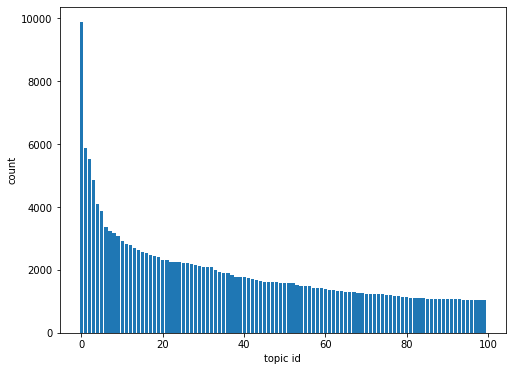

In [ ]:
topic_dist = Counter(topics)
del topic_dist[-1]
plt.figure(figsize=(8, 6))
plt.bar(topic_dist.keys(), topic_dist.values())
plt.xlabel("topic id")
plt.ylabel("count")

In [ ]:
topics, probs = topic_model.transform(docs_train)

Batches:   0%|          | 0/19969 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
topic_model.reduce_topics(docs_train, nr_topics=50)

2022-09-12 03:37:01,686 - BERTopic - Reduced number of topics from 101 to 51


TypeError: ignored

In [ ]:
reduced_topics = topic_model.topics_
reduced_probabilities = topic_model.probabilities_

In [ ]:
topic_model.set_topic_labels(topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=None, separator='|'))
topic_model.visualize_hierarchy(custom_labels=True, color_threshold=1.35)

In [ ]:
topic_model.save('topic modeling/qanon_tweets_50_topics.model')

In [ ]:
all_tweets_df = pd.read_csv('data/tweets_cleaned_sentence.csv')
all_tweets_df = all_tweets_df.fillna('')

all_docs = all_tweets_df['cleaned_text'].tolist()
print(len(all_docs))

923385


In [ ]:
all_topics, all_probs = topic_model.transform(all_docs)

Batches:   0%|          | 0/28856 [00:00<?, ?it/s]

2022-09-12 04:27:48,399 - BERTopic - Reduced dimensionality
2022-09-12 04:40:09,884 - BERTopic - Predicted clusters


Text(0, 0.5, 'count')

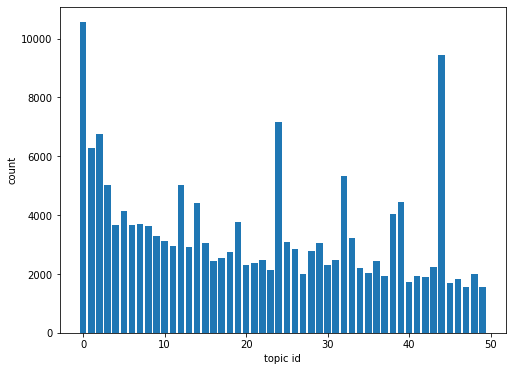

In [ ]:
topic_dist = Counter(all_topics)
del topic_dist[-1]
plt.figure(figsize=(8, 6))
plt.bar(topic_dist.keys(), topic_dist.values())
plt.xlabel("topic id")
plt.ylabel("count")

In [ ]:
len(all_topics)
len(all_probs)
all_tweets_df['topic'] = all_topics
all_tweets_df['topic_probability'] = all_probs

all_tweets_df.to_csv('data/all_tweets_50_topics.csv', index=False)

filtered_tweets_df = all_tweets_df[(all_tweets_df['topic'] != -1) & (all_tweets_df['topic_probability'] > 0.5)]

Text(0, 0.5, 'count')

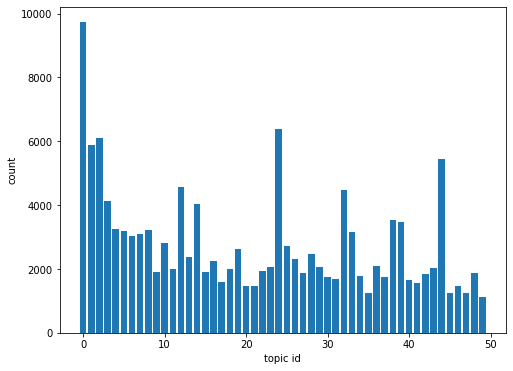

In [ ]:
topic_dist = Counter(filtered_tweets_df['topic'].tolist())
del topic_dist[-1]
plt.figure(figsize=(8, 6))
plt.bar(topic_dist.keys(), topic_dist.values())
plt.xlabel("topic id")
plt.ylabel("count")

In [ ]:
topic_model.visualize_barchart(top_n_topics=50)

In [ ]:
topic_model = BERTopic.load('topic modeling/qanon_tweets_50_topics.model')
fig = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=1.35)
fig.write_html("topic modeling/hierarchical_clustering_full.html")

In [ ]:
topic_model.visualize_barchart(top_n_topics=50)

In [ ]:
fig = topic_model.visualize_hierarchy(topics=[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 15, 18, 19, 20, 23, 25, 26, 27, 36, 39, 41, 42, 46, 47, 48], custom_labels=True, color_threshold=1.4)
fig.write_html("topic modeling/hierarchical_clustering.html")